In [14]:
import json
import os
import glob
from collections import defaultdict
from collections import defaultdict
import pandas as pd
from tqdm import tqdm
import pandas as pd
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)
pd.set_option("display.max_colwidth",None)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle, Arc
import itertools
import re

In [7]:
# ----------------------------
# Paths (edit if needed)
# ----------------------------
PLAYERS_PATH = "data/players/players_743.json"
SQUADS_PATH  = "data/squads/squads_743.json"
EVENTS_GLOB  = os.path.join("data/events", "*.json")   # e.g., events/events_123.json

# ----------------------------
# Load players + squads
# ----------------------------
with open(PLAYERS_PATH, "r", encoding="utf-8") as f:
    players = json.load(f)

with open(SQUADS_PATH, "r", encoding="utf-8") as f:
    squads = json.load(f)

player_id2name = {
    p["id"]: (p.get("commonname") or f'{p.get("firstname","")} {p.get("lastname","")}'.strip())
    for p in players
}
squad_id2name = {s["id"]: s["name"] for s in squads}

# ----------------------------
# Helpers
# ----------------------------
def safe_get(d, *keys, default=None):
    cur = d
    for k in keys:
        if cur is None or k not in cur:
            return default
        cur = cur[k]
    return cur

def is_completed_teammate_pass(ev):
    """
    True if:
      - actionType == PASS
      - result == SUCCESS
      - pass.receiver exists and is TEAMMATE
    """
    if ev.get("actionType") != "PASS":
        return False
    if ev.get("result") != "SUCCESS":
        return False
    p = ev.get("pass")
    if not p:
        return False
    r = p.get("receiver")
    if not r:
        return False
    if r.get("type") != "TEAMMATE":
        return False
    # Need sender too
    if not ev.get("player") or ev["player"].get("id") is None:
        return False
    return True

def build_season_network(events_files, min_shared_minutes=10.0):

    # Pass counts: (team, sender, receiver) -> int
    passes = defaultdict(int)

    # For playtime: (match_id, player_id, team_id) -> list of times (seconds)
    times_seen = defaultdict(list)

    # ----------------------------
    # First pass: read events
    # ----------------------------
    print("Reading event files...")

    for fp in tqdm(events_files, desc="Processing matches"):

        match_id = os.path.splitext(os.path.basename(fp))[0]

        with open(fp, "r", encoding="utf-8") as f:
            events = json.load(f)

        for ev in events:

            t = safe_get(ev, "gameTime", "gameTimeInSec", default=None)
            if t is None:
                continue

            team_id = ev.get("squadId", None)

            # track minutes
            pl = ev.get("player", None)
            if pl is not None and pl.get("id") is not None and team_id is not None:
                pid = pl["id"]
                times_seen[(match_id, pid, team_id)].append(float(t))

            # track passes
            if is_completed_teammate_pass(ev) and team_id is not None:

                sender = ev["player"]["id"]
                receiver = ev["pass"]["receiver"]["playerId"]

                passes[(team_id, sender, receiver)] += 1

    # ----------------------------
    # Build intervals
    # ----------------------------
    print("Building playtime intervals...")

    intervals = defaultdict(dict)
    minutes_rows = []

    for (match_id, pid, team_id), ts in tqdm(
        times_seen.items(),
        desc="Computing player minutes"
    ):

        if len(ts) < 2:
            continue

        start = min(ts)
        end   = max(ts)

        if end <= start:
            continue

        intervals[(match_id, team_id)][pid] = (start, end)

        minutes_rows.append({
            "match_id": match_id,
            "team_id": team_id,
            "team": squad_id2name.get(team_id, team_id),
            "player_id": pid,
            "player": player_id2name.get(pid, pid),
            "minutes_played": (end - start) / 60.0,
            "start_sec": start,
            "end_sec": end
        })

    minutes_df = pd.DataFrame(minutes_rows)

    # ----------------------------
    # Shared minutes
    # ----------------------------
    print("Computing shared minutes...")

    shared_minutes = defaultdict(float)

    for (match_id, team_id), pid2int in tqdm(
        intervals.items(),
        desc="Pairwise overlaps"
    ):

        pids = list(pid2int.keys())

        if len(pids) < 2:
            continue

        for i in range(len(pids)):

            p1 = pids[i]
            s1, e1 = pid2int[p1]

            for j in range(i + 1, len(pids)):

                p2 = pids[j]
                s2, e2 = pid2int[p2]

                overlap_sec = max(0.0, min(e1, e2) - max(s1, s2))

                if overlap_sec <= 0:
                    continue

                overlap_min = overlap_sec / 60.0

                shared_minutes[(team_id, p1, p2)] += overlap_min
                shared_minutes[(team_id, p2, p1)] += overlap_min

    shared_rows = [
        {
            "team_id": team_id,
            "team": squad_id2name.get(team_id, team_id),
            "player_from_id": p1,
            "player_from": player_id2name.get(p1, p1),
            "player_to_id": p2,
            "player_to": player_id2name.get(p2, p2),
            "shared_minutes": mins
        }
        for (team_id, p1, p2), mins in shared_minutes.items()
    ]

    shared_minutes_df = pd.DataFrame(shared_rows)

    # ----------------------------
    # Final edges
    # ----------------------------
    print("Building final network...")

    edge_rows = []

    for (team_id, s, r), n_pass in tqdm(
        passes.items(),
        desc="Normalizing edges"
    ):

        mins = shared_minutes.get((team_id, s, r), 0.0)

        if mins < min_shared_minutes:
            continue

        per90 = n_pass / (mins / 90.0)

        edge_rows.append({
            "team_id": team_id,
            "team": squad_id2name.get(team_id, team_id),
            "from_id": s,
            "from": player_id2name.get(s, s),
            "to_id": r,
            "to": player_id2name.get(r, r),
            "passes": n_pass,
            "shared_minutes": mins,
            "passes_per90_shared": per90
        })

    edges_df = (
        pd.DataFrame(edge_rows)
        .sort_values(["team", "passes_per90_shared"], ascending=[True, False])
        .reset_index(drop=True)
    )

    return edges_df, shared_minutes_df, minutes_df

In [8]:
edges_df, shared_minutes_df, minutes_df = build_season_network(
    events_files=events_files,
    min_shared_minutes=10.0
)

Reading event files...


Processing matches: 100%|██████████| 306/306 [00:04<00:00, 65.59it/s]


Building playtime intervals...


Computing player minutes: 100%|██████████| 9467/9467 [00:00<00:00, 553761.61it/s]


Computing shared minutes...


Pairwise overlaps: 100%|██████████| 612/612 [00:00<00:00, 46961.47it/s]


Building final network...


Normalizing edges: 100%|██████████| 9594/9594 [00:00<00:00, 2825258.20it/s]


In [9]:
edges_df.head(20)

,team_id,team,from_id,from,to_id,to,passes,shared_minutes,passes_per90_shared
0,432,1. FC Heidenheim 1846,23256,Stefan Schimmer,22963,Nikola Dovedan,5,32.974553,13.646887
1,432,1. FC Heidenheim 1846,10483,Denis Thomalla,23256,Stefan Schimmer,2,16.696585,10.780648
2,432,1. FC Heidenheim 1846,23088,Florian Pick,6371,Niklas Beste,8,77.217887,9.324265
3,432,1. FC Heidenheim 1846,46957,Adrian Beck,23256,Stefan Schimmer,2,19.774752,9.102516
4,432,1. FC Heidenheim 1846,10244,Norman Theuerkauf,23088,Florian Pick,10,106.013887,8.489454
5,432,1. FC Heidenheim 1846,66510,Tim Siersleben,1443,Benedikt Gimber,1,10.851168,8.294038
6,432,1. FC Heidenheim 1846,23088,Florian Pick,46957,Adrian Beck,9,106.138552,7.631534
7,432,1. FC Heidenheim 1846,44884,Patrick Mainka,1457,Marnon Busch,88,1078.617008,7.342736
8,432,1. FC Heidenheim 1846,73465,Marvin Pieringer,23256,Stefan Schimmer,3,38.181505,7.071487
9,432,1. FC Heidenheim 1846,10483,Denis Thomalla,23088,Florian Pick,10,137.153970,6.561968


In [10]:
# ----------------------------
# Paths
# ----------------------------
PLAYERS_PATH = "data/players/players_743.json"
SQUADS_PATH  = "data/squads/squads_743.json"
EVENTS_GLOB  = os.path.join("data/events", "*.json")

# ----------------------------
# Load players + squads
# ----------------------------
with open(PLAYERS_PATH, "r", encoding="utf-8") as f:
    players = json.load(f)  # players have id, commonname, currentSquadId, ...  [oai_citation:1‡players_743.json](sediment://file_00000000bf5071f8a46fff0856c4dd0c)

with open(SQUADS_PATH, "r", encoding="utf-8") as f:
    squads = json.load(f)

player_id2name = {
    p["id"]: (p.get("commonname") or f'{p.get("firstname","")} {p.get("lastname","")}'.strip())
    for p in players
}
player_id2current_squad = {p["id"]: p.get("currentSquadId") for p in players}
squad_id2name = {s["id"]: s["name"] for s in squads}

# ----------------------------
# Helpers
# ----------------------------
def safe_get(d, *keys, default=None):
    cur = d
    for k in keys:
        if cur is None or k not in cur:
            return default
        cur = cur[k]
    return cur

def get_xy_from_event(ev, use_adj=True):
    """
    Returns (x,y) from event start coordinates.
    Prefer adjCoordinates if present (normalizes orientation).
    """
    if ev.get("start") is None:
        return None

    if use_adj:
        x = safe_get(ev, "start", "adjCoordinates", "x", default=None)
        y = safe_get(ev, "start", "adjCoordinates", "y", default=None)
        if x is not None and y is not None:
            return float(x), float(y)

    x = safe_get(ev, "start", "coordinates", "x", default=None)
    y = safe_get(ev, "start", "coordinates", "y", default=None)
    if x is None or y is None:
        return None
    return float(x), float(y)

# ----------------------------
# Choose which events define "position"
# ----------------------------
# Good default: ball actions + receptions (exclude NO_VIDEO/OUT etc.)
ALLOWED_ACTION_TYPES = {
    "PASS", "RECEPTION", "DRIBBLE", "SHOT", "CROSS", "CARRY", "CLEARANCE",
    "DUEL", "TACKLE", "INTERCEPTION", "LOOSE_BALL_REGAIN", "THROW_IN"
}

# If you want stricter (only in-possession), uncomment:
# ALLOWED_PHASES = {"IN_POSSESSION", "SET_PIECE", "SECOND_BALL"}
ALLOWED_PHASES = None  # no phase filter by default

# ----------------------------
# Scan all events (mean position by player AND team-in-that-event)
# ----------------------------
sum_x = defaultdict(float)   # key = (pid, team_id)
sum_y = defaultdict(float)
count = defaultdict(int)

for fp in tqdm(events_files, desc="Computing mean positions"):
    with open(fp, "r", encoding="utf-8") as f:
        events = json.load(f)

    for ev in events:
        pl = ev.get("player")
        team_id = ev.get("squadId")

        if not pl or pl.get("id") is None or team_id is None:
            continue

        if ev.get("actionType") not in ALLOWED_ACTION_TYPES:
            continue
        if ALLOWED_PHASES is not None and ev.get("phase") not in ALLOWED_PHASES:
            continue

        xy = get_xy_from_event(ev, use_adj=True)
        if xy is None:
            continue

        pid = pl["id"]
        x, y = xy

        key = (pid, team_id)
        sum_x[key] += x
        sum_y[key] += y
        count[key] += 1

# ----------------------------
# Build final dataframe: one row per (player, team) observed in events
# ----------------------------
rows = []
for (pid, team_id), n in count.items():
    rows.append({
        "player_id": pid,
        "player": player_id2name.get(pid, pid),
        "team_id": team_id,
        "team": squad_id2name.get(team_id, team_id),
        "mean_x": sum_x[(pid, team_id)] / n,
        "mean_y": sum_y[(pid, team_id)] / n,
        "n_events_used": n
    })

df_players_pos_played = (
    pd.DataFrame(rows)
    .sort_values(["team", "player"])
    .reset_index(drop=True)
)

df_players_pos_played

Computing mean positions: 100%|██████████| 306/306 [00:04<00:00, 63.08it/s]


,player_id,player,team_id,team,mean_x,mean_y,n_events_used
0,46957,Adrian Beck,432,1. FC Heidenheim 1846,5.353774,3.720283,1272
1,1443,Benedikt Gimber,432,1. FC Heidenheim 1846,-21.211793,11.290533,2493
2,49836,Christian Kühlwetter,432,1. FC Heidenheim 1846,9.620000,8.840000,5
3,10483,Denis Thomalla,432,1. FC Heidenheim 1846,0.802381,3.308333,504
4,63569,Eren Dinkçi,432,1. FC Heidenheim 1846,9.092740,-15.021246,2617
5,23088,Florian Pick,432,1. FC Heidenheim 1846,12.684190,7.851581,506
6,52004,Jan Schöppner,432,1. FC Heidenheim 1846,-2.712293,-3.498237,1928
7,1313,Jonas Föhrenbach,432,1. FC Heidenheim 1846,-6.411099,20.920738,3631
8,10254,Kevin Müller,432,1. FC Heidenheim 1846,-39.652069,-0.443753,2489
9,49171,Kevin Sessa,432,1. FC Heidenheim 1846,3.750745,-4.877647,1275


In [18]:
def draw_pitch(
    ax=None,
    length=105, width=68,        # meters
    line_color="white",          # white lines
    lw=2.5,
    grass_colors=("#2e7d32", "#388e3c"),
    n_stripes=14,
    show=True
):
    """
    Draw a soccer pitch with striped grass and white lines.
    Pitch coordinates are in meters: x in [0,105], y in [0,68].
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 7))
    else:
        fig = ax.figure

    # Grass stripes
    stripe_width = length / n_stripes
    for i in range(n_stripes):
        color = grass_colors[i % 2]
        ax.add_patch(
            Rectangle(
                (i * stripe_width, 0),
                stripe_width,
                width,
                facecolor=color,
                edgecolor="none",
                zorder=0
            )
        )

    # Outer boundary
    ax.add_patch(
        Rectangle((0, 0), length, width,
                  fill=False, edgecolor=line_color, linewidth=lw, zorder=5)
    )

    # Halfway line
    ax.plot([length/2, length/2], [0, width], color=line_color, lw=lw, zorder=5)

    # Center circle + spot
    centre = (length/2, width/2)
    ax.add_patch(Circle(centre, 9.15, fill=False, edgecolor=line_color, linewidth=lw, zorder=5))
    ax.add_patch(Circle(centre, 0.3, color=line_color, zorder=5))

    # Penalty areas
    ax.add_patch(Rectangle((0, (width/2)-20.16), 16.5, 40.32,
                           fill=False, edgecolor=line_color, linewidth=lw, zorder=5))
    ax.add_patch(Rectangle((length-16.5, (width/2)-20.16), 16.5, 40.32,
                           fill=False, edgecolor=line_color, linewidth=lw, zorder=5))

    # 6-yard boxes
    ax.add_patch(Rectangle((0, (width/2)-9.16), 5.5, 18.32,
                           fill=False, edgecolor=line_color, linewidth=lw, zorder=5))
    ax.add_patch(Rectangle((length-5.5, (width/2)-9.16), 5.5, 18.32,
                           fill=False, edgecolor=line_color, linewidth=lw, zorder=5))

    # Penalty spots
    ax.add_patch(Circle((11, width/2), 0.3, color=line_color, zorder=5))
    ax.add_patch(Circle((length-11, width/2), 0.3, color=line_color, zorder=5))

    # Penalty arcs
    ax.add_patch(Arc((11, width/2), 18.3, 18.3, angle=0, theta1=310, theta2=50,
                     color=line_color, lw=lw, zorder=5))
    ax.add_patch(Arc((length-11, width/2), 18.3, 18.3, angle=0, theta1=130, theta2=230,
                     color=line_color, lw=lw, zorder=5))

    # Axis settings
    ax.set_xlim(-3, length+3)
    ax.set_ylim(-3, width+3)
    ax.set_aspect("equal")
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

    if show:
        plt.show()

    return fig, ax


def _to_105x68(mean_x, mean_y, xlim=(-52.5, 52.5), ylim=(-34, 34), length=105, width=68):
    """
    Convert your mean_x, mean_y (likely centered coords) into [0,105]x[0,68].
    If your df is already in 0..105 / 0..68, this mapping will look wrong — see note below.
    """
    x = (mean_x - xlim[0]) / (xlim[1] - xlim[0]) * length
    y = (mean_y - ylim[0]) / (ylim[1] - ylim[0]) * width
    return x, y


def plot_player_mean_position(
    player_name: str,
    df_players_pos_played: pd.DataFrame,
    team: str | None = None,
    annotate: bool = True,
    savepath: str | None = None,
    assume_centered_coords: bool = True,   # True if mean_x in [-52.5,52.5], mean_y in [-34,34]
):
    """
    Input:
      - player_name: player name (substring, case-insensitive) as appears in df['player']
      - df_players_pos_played: must include columns:
            ['player','team','mean_x','mean_y','n_events_used']
        (optionally multiple rows if player played for multiple teams)
      - team (optional): choose one team if player appears for multiple teams
      - assume_centered_coords:
            True  -> convert mean_x/mean_y from [-52.5,52.5]x[-34,34] to pitch meters [0,105]x[0,68]
            False -> treat mean_x/mean_y as already in [0,105]x[0,68]

    Output:
      - draws pitch (your style) and plots mean position point(s)
      - returns dataframe rows used for plotting
    """
    # Match player (substring)
    mask = df_players_pos_played["player"].astype(str).str.lower().str.contains(player_name.lower(), na=False)
    m = df_players_pos_played.loc[mask].copy()

    if m.empty:
        raise ValueError(f"No player found matching: '{player_name}'")

    if team is not None:
        m2 = m[m["team"].astype(str).str.lower() == team.lower()].copy()
        if m2.empty:
            teams = sorted(m["team"].dropna().unique().tolist())
            raise ValueError(f"Player '{player_name}' found, but not for team='{team}'. Available teams: {teams}")
        m = m2

    # Create pitch
    fig, ax = draw_pitch(show=False)

    # Convert coords if needed
    xs, ys = [], []
    for _, r in m.iterrows():
        if assume_centered_coords:
            x, y = _to_105x68(r["mean_x"], r["mean_y"])
        else:
            x, y = float(r["mean_x"]), float(r["mean_y"])
        xs.append(x)
        ys.append(y)

    # Plot points
    ax.scatter(xs, ys, s=140, zorder=10)

    # Title
    title = m["player"].iloc[0]
    if len(m) == 1:
        title += f" — {m['team'].iloc[0]}"
    else:
        title += " — multiple teams"
    ax.set_title(title, fontsize=18)

    # Labels
    if annotate:
        for (x, y), (_, r) in zip(zip(xs, ys), m.iterrows()):
            label = f"{r['team']} (n={int(r['n_events_used'])})"
            ax.annotate(label, (x, y), xytext=(8, 8), textcoords="offset points",
                        fontsize=12, zorder=11)

    # Save / show
    if savepath is not None:
        plt.savefig(savepath, dpi=300, bbox_inches="tight")

    plt.show()
    return m


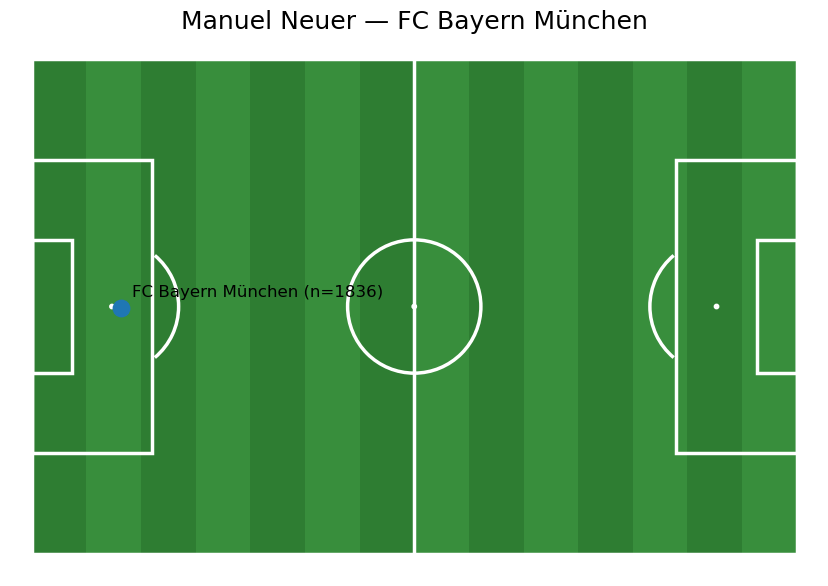

,player_id,player,team_id,team,mean_x,mean_y,n_events_used
272,582,Manuel Neuer,33,FC Bayern München,-40.233769,-0.218137,1836


In [22]:
plot_player_mean_position("Manuel Neuer", df_players_pos_played)

In [31]:
def _centered_to_pitch_xy(x, y, length=105, width=68):
    # from [-52.5, 52.5] and [-34, 34] to [0,105] and [0,68]
    return (x + length/2), (y + width/2)

def plot_team_passing_network_on_pitch(
    team,
    edges_df,
    df_players_pos_played,
    squad_id2name=None,
    coords_centered=True,
    min_edge_weight=0.0,
    top_k_edges=None,          # e.g. 200 to reduce clutter
    node_size=140,
    edge_alpha=0.35,
    annotate_on_click=True
):
    """
    team: team name (string) OR team_id (int)
    edges_df: output of build_season_network (must have columns: team_id, team, from_id, to_id, passes_per90_shared)
    df_players_pos_played: must have columns: team_id, team, player_id, player, mean_x, mean_y
    squad_id2name: optional dict {team_id: team_name} for mapping if you pass a team_id
    coords_centered: True if mean_x/mean_y are centered coords; False if already [0,105]x[0,68]
    """

    # ----------------------------
    # Resolve team_id + team_name
    # ----------------------------
    if isinstance(team, (int, np.integer)):
        team_id = int(team)
        if squad_id2name is not None:
            team_name = squad_id2name.get(team_id, str(team_id))
        else:
            # fallback: try from edges_df / df
            cand = pd.concat([
                edges_df.loc[edges_df["team_id"] == team_id, ["team"]].drop_duplicates(),
                df_players_pos_played.loc[df_players_pos_played["team_id"] == team_id, ["team"]].drop_duplicates()
            ], axis=0).drop_duplicates()
            team_name = cand["team"].iloc[0] if len(cand) else str(team_id)
    else:
        team_name = str(team)
        # try match by exact name (case-insensitive)
        m = df_players_pos_played["team"].astype(str).str.lower() == team_name.lower()
        if m.any():
            team_id = int(df_players_pos_played.loc[m, "team_id"].iloc[0])
        else:
            m2 = edges_df["team"].astype(str).str.lower() == team_name.lower()
            if not m2.any():
                raise ValueError(f"Team not found: '{team}'. Check df_players_pos_played['team'] / edges_df['team'].")
            team_id = int(edges_df.loc[m2, "team_id"].iloc[0])
            team_name = edges_df.loc[m2, "team"].iloc[0]

    # ----------------------------
    # Subset nodes (players) for this team
    # ----------------------------
    nodes = df_players_pos_played[df_players_pos_played["team_id"] == team_id].copy()
    if nodes.empty:
        raise ValueError(f"No mean positions found for team_id={team_id} ({team_name}).")

    # Convert positions to pitch coords [0,105]x[0,68]
    if coords_centered:
        xy = nodes.apply(lambda r: _centered_to_pitch_xy(r["mean_x"], r["mean_y"]), axis=1)
        nodes["px"] = [v[0] for v in xy]
        nodes["py"] = [v[1] for v in xy]
    else:
        nodes["px"] = nodes["mean_x"].astype(float)
        nodes["py"] = nodes["mean_y"].astype(float)

    # Create fast maps
    pid2pos = {int(r.player_id): (float(r.px), float(r.py)) for r in nodes.itertuples(index=False)}
    pid2name = {int(r.player_id): str(r.player) for r in nodes.itertuples(index=False)}

    # ----------------------------
    # Subset edges for this team
    # ----------------------------
    e = edges_df[edges_df["team_id"] == team_id].copy()
    if e.empty:
        # still draw nodes; no edges
        e = e.iloc[0:0]

    # Filter edges by min weight and optionally keep top K
    e = e[e["passes_per90_shared"] >= float(min_edge_weight)].copy()
    e = e[e["from_id"].isin(pid2pos.keys()) & e["to_id"].isin(pid2pos.keys())].copy()

    if top_k_edges is not None and len(e) > int(top_k_edges):
        e = e.sort_values("passes_per90_shared", ascending=False).head(int(top_k_edges))

    # Normalize edge linewidths (no explicit colors)
    if len(e) > 0:
        w = e["passes_per90_shared"].astype(float).values
        w_min, w_max = float(w.min()), float(w.max())
        if w_max > w_min:
            lw = 0.5 + 4.0 * (w - w_min) / (w_max - w_min)
        else:
            lw = np.full_like(w, 2.0, dtype=float)
        e["_lw"] = lw
    else:
        e["_lw"] = []

    # ----------------------------
    # Draw
    # ----------------------------
    fig, ax = draw_pitch(show=False)
    ax.set_title(f"{team_name} — passing network (per90 shared)", fontsize=18)

    # Edges first (behind nodes)
    for _, row in e.iterrows():
    
        s = int(row["from_id"])
        r = int(row["to_id"])
    
        x1, y1 = pid2pos[s]
        x2, y2 = pid2pos[r]
    
        ax.plot(
            [x1, x2],
            [y1, y2],
            linewidth=float(row["_lw"]),
            alpha=edge_alpha,
            zorder=6
        )

    # ----------------------------
    # Nodes
    # ----------------------------
    node_pids = list(pid2pos.keys())
    X = [pid2pos[pid][0] for pid in node_pids]
    Y = [pid2pos[pid][1] for pid in node_pids]

    ax.scatter(X, Y, s=node_size, zorder=10)

    # ----------------------------
    # Labels (player names)
    # ----------------------------
    label_nodes = True
    label_fontsize = 8
    label_offset = (0.8, 0.6)   # (dx, dy) in pitch meters
    label_min_events = 0        # set e.g. 30 to label only main players

    # If you have n_events_used in nodes, we can filter labels:
    # nodes has columns ['player_id','player','px','py', ...] if built that way
    # We'll build a quick map from pid -> n_events_used if available.
    if "n_events_used" in nodes.columns:
        pid2n = dict(zip(nodes["player_id"].astype(int), nodes["n_events_used"].astype(int)))
    else:
        pid2n = {}

    for pid in node_pids:
        if pid2n.get(pid, 999999) < label_min_events:
            continue

        x, y = pid2pos[pid]
        name = pid2name.get(pid, str(pid))

        ax.text(
            x + label_offset[0],
            y + label_offset[1],
            name,
            fontsize=label_fontsize,
            zorder=20
        )

    plt.show()
    return fig, ax

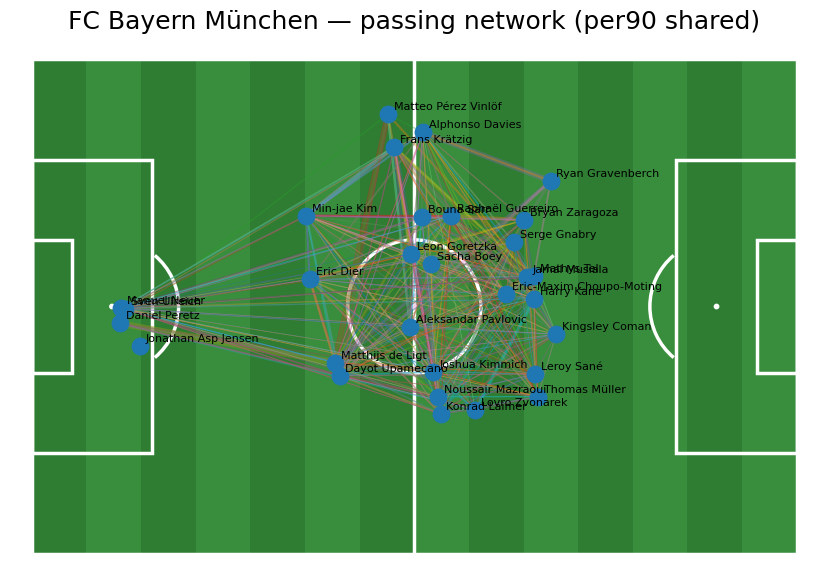

(<Figure size 1200x700 with 1 Axes>,
 <Axes: title={'center': 'FC Bayern München — passing network (per90 shared)'}>)

In [32]:
plot_team_passing_network_on_pitch(
    team="FC Bayern München",      # oppure team_id=38
    edges_df=edges_df,
    df_players_pos_played=df_players_pos_played,
    squad_id2name=squad_id2name,  # opzionale ma utile
    coords_centered=True,
    top_k_edges=None,              # per non fare “spaghetti”
    min_edge_weight=0.0          # filtra archi deboli
)

In [18]:
# ----------------------------
# 0) Lista squadre (la tua)
# ----------------------------
SQUADS_LIST = [
    {"id": 27, "name": "1. FC Köln"},
    {"id": 29, "name": "Borussia Dortmund"},
    {"id": 30, "name": "VfL Wolfsburg"},
    {"id": 31, "name": "TSG 1899 Hoffenheim"},
    {"id": 32, "name": "Borussia Mönchengladbach"},
    {"id": 33, "name": "FC Bayern München"},
    {"id": 34, "name": "SC Freiburg"},
    {"id": 35, "name": "Eintracht Frankfurt"},
    {"id": 36, "name": "SV Darmstadt 98"},
    {"id": 37, "name": "RasenBallsport Leipzig"},
    {"id": 38, "name": "SV Werder Bremen"},
    {"id": 39, "name": "FC Augsburg"},
    {"id": 41, "name": "Bayer 04 Leverkusen"},
    {"id": 42, "name": "1. FSV Mainz 05"},
    {"id": 46, "name": "VfB Stuttgart"},
    {"id": 416, "name": "VfL Bochum"},
    {"id": 432, "name": "1. FC Heidenheim 1846"},
    {"id": 446, "name": "1. FC Union Berlin"},
]

# ----------------------------
# 1) Carica events_files (senza glob)
# ----------------------------
EVENTS_DIR = "data/events"
if not os.path.isdir(EVENTS_DIR):
    raise FileNotFoundError(f"EVENTS_DIR not found: {EVENTS_DIR}")

events_files = sorted(
    os.path.join(EVENTS_DIR, fn)
    for fn in os.listdir(EVENTS_DIR)
    if fn.endswith(".json")
)

if len(events_files) == 0:
    raise FileNotFoundError(f"No .json files found in {EVENTS_DIR}")

# ----------------------------
# 2) Costruisci i dataframe se non esistono già
#    (build_season_network deve essere definita/importata nel notebook)
# ----------------------------
if "edges_df" not in globals() or "minutes_df" not in globals():
    edges_df, shared_minutes_df, minutes_df = build_season_network(
        events_files,
        min_shared_minutes=10.0
    )

# Controlli minimi sulle colonne attese
required_minutes_cols = {"team_id", "player_id", "player"}
required_edges_cols = {"team_id", "from_id", "to_id", "passes", "shared_minutes", "passes_per90_shared"}

missing_m = required_minutes_cols - set(minutes_df.columns)
missing_e = required_edges_cols - set(edges_df.columns)

if missing_m:
    raise ValueError(f"minutes_df missing columns: {missing_m}")
if missing_e:
    raise ValueError(f"edges_df missing columns: {missing_e}")

# ----------------------------
# 3) Utility per nomi file "safe"
# ----------------------------
def slugify(s: str) -> str:
    s = s.strip().lower()
    s = s.replace("ö", "oe").replace("ä", "ae").replace("ü", "ue").replace("ß", "ss")
    s = re.sub(r"\s+", "_", s)
    s = re.sub(r"[^a-z0-9_\.]+", "", s)
    return s

# ----------------------------
# 4) Output folder
# ----------------------------
OUT_DIR = "Fully_connected_team_networks"
os.makedirs(OUT_DIR, exist_ok=True)

# ----------------------------
# 5) Crea e salva rete fully-connected per ogni team
#    (diretta i->j, senza self-loops)
# ----------------------------
for squad in SQUADS_LIST:
    team_id = int(squad["id"])
    team_name = squad["name"]

    # players presenti per quella squadra (stagione intera)
    players_team = (
        minutes_df.loc[minutes_df["team_id"] == team_id, ["player_id", "player"]]
        .dropna()
        .drop_duplicates()
        .sort_values("player_id")
        .reset_index(drop=True)
    )

    if players_team.empty:
        print(f"[SKIP] {team_name} (team_id={team_id}): no players in minutes_df")
        continue

    # tutte le coppie ordinate (i -> j), i != j
    pids = players_team["player_id"].tolist()
    all_pairs = [(i, j) for i, j in itertools.product(pids, pids) if i != j]

    full_df = pd.DataFrame(all_pairs, columns=["from_id", "to_id"])
    full_df["team_id"] = team_id
    full_df["team"] = team_name

    # aggiungi nomi giocatori
    pid2name = dict(zip(players_team["player_id"], players_team["player"]))
    full_df["from"] = full_df["from_id"].map(pid2name)
    full_df["to"] = full_df["to_id"].map(pid2name)

    # merge con archi osservati
    edges_team = edges_df.loc[edges_df["team_id"] == team_id, [
        "team_id", "from_id", "to_id", "passes", "shared_minutes", "passes_per90_shared"
    ]].copy()

    full_df = full_df.merge(
        edges_team,
        on=["team_id", "from_id", "to_id"],
        how="left"
    )

    # fill 0 per edges non osservati
    for col in ["passes", "shared_minutes", "passes_per90_shared"]:
        full_df[col] = full_df[col].fillna(0.0)

    # salva edges fully-connected
    out_path = os.path.join(OUT_DIR, f"{slugify(team_name)}__fully_connected.csv")
    full_df.to_csv(out_path, index=False)

    # salva anche nodes
    nodes_path = os.path.join(OUT_DIR, f"{slugify(team_name)}__nodes.csv")
    players_team.assign(team_id=team_id, team=team_name).to_csv(nodes_path, index=False)

    print(f"[OK] {team_name} -> {out_path} | {nodes_path}")

[OK] 1. FC Köln -> Fully_connected_team_networks/1._fc_koeln__fully_connected.csv | Fully_connected_team_networks/1._fc_koeln__nodes.csv
[OK] Borussia Dortmund -> Fully_connected_team_networks/borussia_dortmund__fully_connected.csv | Fully_connected_team_networks/borussia_dortmund__nodes.csv
[OK] VfL Wolfsburg -> Fully_connected_team_networks/vfl_wolfsburg__fully_connected.csv | Fully_connected_team_networks/vfl_wolfsburg__nodes.csv
[OK] TSG 1899 Hoffenheim -> Fully_connected_team_networks/tsg_1899_hoffenheim__fully_connected.csv | Fully_connected_team_networks/tsg_1899_hoffenheim__nodes.csv
[OK] Borussia Mönchengladbach -> Fully_connected_team_networks/borussia_moenchengladbach__fully_connected.csv | Fully_connected_team_networks/borussia_moenchengladbach__nodes.csv
[OK] FC Bayern München -> Fully_connected_team_networks/fc_bayern_muenchen__fully_connected.csv | Fully_connected_team_networks/fc_bayern_muenchen__nodes.csv
[OK] SC Freiburg -> Fully_connected_team_networks/sc_freiburg__f

In [19]:
# -----------------------------
# 0) KPI mapping (id -> name) dalla tua lista
# -----------------------------
KPI_LIST = [
    {"id": 0, "name": "BYPASSED_OPPONENTS"},
    {"id": 1, "name": "BYPASSED_OPPONENTS_NUMBER"},
    {"id": 2, "name": "BYPASSED_DEFENDERS"},
    {"id": 3, "name": "BYPASSED_OPPONENTS_WO_VERIFICATION"},
    {"id": 4, "name": "BYPASSED_DEFENDERS_WO_VERIFICATION"},
    {"id": 6, "name": "BYPASSED_OPPONENTS_BY_ACTION_SECOND_BALL"},
    {"id": 7, "name": "BYPASSED_OPPONENTS_RECEIVING"},
    {"id": 8, "name": "BYPASSED_OPPONENTS_RECEIVING_NUMBER"},
    {"id": 9, "name": "BYPASSED_DEFENDERS_RECEIVING"},
    {"id": 10, "name": "BYPASSED_OPPONENTS_RECEIVING_DUETO_VERIFICATION"},
    {"id": 15, "name": "NEUTRAL_PLAY_NUMBER"},
    {"id": 16, "name": "REVERSE_PLAY_ADDED_OPPONENTS"},
    {"id": 17, "name": "REVERSE_PLAY_NUMBER"},
    {"id": 20, "name": "BALL_LOSS_ADDED_OPPONENTS"},
    {"id": 21, "name": "BALL_LOSS_REMOVED_TEAMMATES"},
    {"id": 22, "name": "BALL_LOSS_NUMBER"},
    {"id": 23, "name": "BALL_WIN_ADDED_TEAMMATES"},
    {"id": 24, "name": "BALL_WIN_REMOVED_OPPONENTS"},
    {"id": 25, "name": "BALL_WIN_REMOVED_OPPONENTS_DEFENDERS"},
    {"id": 27, "name": "BALL_WIN_NUMBER"},
    {"id": 28, "name": "GOALS"},
    {"id": 29, "name": "BYPASSED_OPPONENTS_MIDFIELD"},
    {"id": 33, "name": "BALL_LOSS_ADDED_OPPONENTS_DEFENDERS"},
    {"id": 36, "name": "BALL_WIN_ADDED_TEAMMATES_DEFENDERS"},
    {"id": 37, "name": "REVERSE_PLAY_ADDED_OPPONENTS_DEFENDERS"},
    {"id": 38, "name": "OWNGOALS"},
    {"id": 47, "name": "RED_CARD"},
    {"id": 49, "name": "CRITICAL_BALL_LOSS_NUMBER"},
    {"id": 69, "name": "BALL_LOSS_REMOVED_TEAMMATES_DEFENDERS"},
    {"id": 74, "name": "BYPASSED_DEFENDERS_BY_ACTION_SECOND_BALL"},
    {"id": 77, "name": "ASSISTS"},
    {"id": 82, "name": "SHOT_XG"},
    {"id": 83, "name": "PACKING_XG"},
    {"id": 90, "name": "SUCCESSFUL_PASSES"},
    {"id": 91, "name": "UNSUCCESSFUL_PASSES"},
    {"id": 92, "name": "OFFENSIVE_TOUCHES"},
    {"id": 93, "name": "DEFENSIVE_TOUCHES"},
    {"id": 94, "name": "WON_GROUND_DUELS"},
    {"id": 95, "name": "LOST_GROUND_DUELS"},
    {"id": 96, "name": "WON_AERIAL_DUELS"},
    {"id": 97, "name": "LOST_AERIAL_DUELS"},
    {"id": 100, "name": "SHOT_AT_GOAL_NUMBER"},
    {"id": 101, "name": "SHOT_AT_GOAL_OFF_TARGET_NUMBER"},
    {"id": 1399, "name": "BYPASSED_OPPONENTS_RAW"},
    {"id": 1400, "name": "BYPASSED_OPPONENTS_DEFENDERS_RAW"},
    {"id": 1401, "name": "POSTSHOT_XG"},
    {"id": 1404, "name": "PXT_PASS"},
    {"id": 1405, "name": "PXT_DRIBBLE"},
    {"id": 1406, "name": "PXT_SETPIECE"},
    {"id": 1407, "name": "PXT_BLOCK"},
    {"id": 1408, "name": "PXT_SHOT"},
    {"id": 1409, "name": "PXT_BALL_WIN"},
    {"id": 1410, "name": "PXT_FOUL"},
    {"id": 1411, "name": "PXT_NO_VIDEO"},
    {"id": 1412, "name": "PXT_REC"},
    {"id": 1413, "name": "OPP_PXT_PASS"},
    {"id": 1414, "name": "OPP_PXT_DRIBBLE"},
    {"id": 1415, "name": "OPP_PXT_SETPIECE"},
    {"id": 1416, "name": "OPP_PXT_BLOCK"},
    {"id": 1417, "name": "OPP_PXT_SHOT"},
    {"id": 1418, "name": "OPP_PXT_BALL_WIN"},
    {"id": 1419, "name": "OPP_PXT_FOUL"},
    {"id": 1420, "name": "OPP_PXT_NO_VIDEO"},
    {"id": 1421, "name": "OPP_PXT_BALL_LOSS"},
    {"id": 1431, "name": "NEUTRAL_PASSES"},
    {"id": 1515, "name": "SHOT_AT_GOAL_NUMBER_ON_TARGET"},
    {"id": 1516, "name": "SHOT_AT_GOAL_NUMBER_SUCCESS"},
    {"id": 1517, "name": "SHOT_AT_GOAL_NUMBER_SAVED"},
    {"id": 1518, "name": "SHOT_AT_GOAL_NUMBER_CAUGHT"},
    {"id": 1519, "name": "SHOT_AT_GOAL_NUMBER_BLOCKED"},
    {"id": 1520, "name": "SHOT_AT_GOAL_NUMBER_OTHER"},
    {"id": 1522, "name": "DEF_PXT_PASS"},
    {"id": 1523, "name": "DEF_PXT_DRIBBLE"},
    {"id": 1524, "name": "DEF_PXT_SETPIECE"},
    {"id": 1525, "name": "DEF_PXT_BLOCK"},
    {"id": 1526, "name": "DEF_PXT_SHOT"},
    {"id": 1527, "name": "DEF_PXT_BALL_WIN"},
    {"id": 1528, "name": "DEF_PXT_NOVIDEO"},
    {"id": 1529, "name": "DEF_PXT_BALL_LOSS"},
    {"id": 1530, "name": "DEF_PXT_FOUL"},
    {"id": 1531, "name": "PXT_PASSIVE"},
    {"id": 1532, "name": "PXT_OTHER"},
    {"id": 1533, "name": "PXT_FOULED"},
    {"id": 1534, "name": "DEF_PXT_ACTIVE"},
    {"id": 1535, "name": "DEF_PXT_OTHER"},
    {"id": 1536, "name": "NUMBER_OF_PRESSES"},
    {"id": 1610, "name": "SECOND_BALL_START"},
    {"id": 1611, "name": "SECOND_BALL_WIN"},
    {"id": 1612, "name": "DISTANCE_TO_GOAL_COVERED_FDR"},
    {"id": 1613, "name": "DISTANCE_TO_GOAL_COVERED_DRIBBLE"},
    {"id": 1633, "name": "PXT_ATTACK"},
    {"id": 1634, "name": "PXT_DEFEND"},
    {"id": 1635, "name": "DEF_PXT_ATTACK"},
    {"id": 1636, "name": "DEF_PXT_DEFEND"},
    {"id": 1637, "name": "YELLOW_CARD"},
    {"id": 1638, "name": "SECOND_YELLOW_CARD"},
    {"id": 1693, "name": "SHOT_XG_FROM_PASSES"},
    {"id": 1694, "name": "SHOT_CREATING_ACTIONS"},
    {"id": 1715, "name": "PRE_ASSISTS"},
    {"id": 1780, "name": "SHOT_ASSISTS"},
    {"id": 1781, "name": "EXPECTED_SHOT_ASSISTS"},
    {"id": 1782, "name": "EXPECTED_GOAL_ASSISTS"},
    {"id": 1783, "name": "EXPECTED_PASSES"},
]

KPI_ID2NAME = {int(d["id"]): d["name"] for d in KPI_LIST}

# -----------------------------
# PATHS
# -----------------------------
KPI_DIR = os.path.expanduser("data/player_kpis")
NODES_DIR = "Fully_connected_team_networks"
OUT_DIR = "Fully_connected_team_networks_with_kpis"

os.makedirs(OUT_DIR, exist_ok=True)

if not os.path.isdir(KPI_DIR):
    raise FileNotFoundError(f"KPI_DIR not found: {KPI_DIR}")

if not os.path.isdir(NODES_DIR):
    raise FileNotFoundError(f"NODES_DIR not found: {NODES_DIR}")

# -----------------------------
# 1) Read + explode all KPI jsons
# -----------------------------
rows = []

kpi_files = sorted(
    os.path.join(KPI_DIR, fn)
    for fn in os.listdir(KPI_DIR)
    if fn.endswith(".json")
)

if len(kpi_files) == 0:
    raise FileNotFoundError(f"No .json files found in {KPI_DIR}")

for fp in kpi_files:
    with open(fp, "r", encoding="utf-8") as f:
        data = json.load(f)

    match_id = data.get("matchId")

    for side_key in ["squadHome", "squadAway"]:
        squad = data.get(side_key, {})
        team_id = squad.get("id")
        players = squad.get("players", [])

        for p in players:
            player_id = p.get("id")
            kpis = p.get("kpis", [])

            for kv in kpis:
                kpi_id = kv.get("kpiId")
                value = kv.get("value")
                if player_id is None or kpi_id is None:
                    continue

                # alcuni value possono arrivare come stringa
                try:
                    value_f = float(value) if value is not None else None
                except (TypeError, ValueError):
                    value_f = None

                rows.append({
                    "matchId": match_id,
                    "team_id": team_id,
                    "player_id": int(player_id),
                    "kpiId": int(kpi_id),
                    "value": value_f
                })

kpi_long = pd.DataFrame(rows).dropna(subset=["value"])

# -----------------------------
# 2) mean/std per player per KPI
# -----------------------------
kpi_stats = (
    kpi_long
    .groupby(["player_id", "kpiId"])["value"]
    .agg(mean="mean", std="std")
    .reset_index()
)

# -----------------------------
# 3) Wide format con NOMI KPI:
#    <KPI_NAME>_mean e <KPI_NAME>_std
# -----------------------------
kpi_stats["kpi_name"] = kpi_stats["kpiId"].map(lambda x: KPI_ID2NAME.get(int(x), f"KPI_{int(x)}"))

wide = kpi_stats.pivot(index="player_id", columns="kpi_name", values=["mean", "std"])

# Flatten colonne: (stat, name) -> name_stat
wide.columns = [f"{name}_{stat}" for (stat, name) in wide.columns]
wide = wide.reset_index()

# (opzionale) ordina colonne in modo stabile: player_id, poi alfabetico
base_cols = ["player_id"]
other_cols = sorted([c for c in wide.columns if c not in base_cols])
wide = wide[base_cols + other_cols]

# -----------------------------
# 4) Merge in ogni nodes csv
# -----------------------------
node_files = sorted(
    os.path.join(NODES_DIR, fn)
    for fn in os.listdir(NODES_DIR)
    if fn.endswith("__nodes.csv")
)

if len(node_files) == 0:
    raise FileNotFoundError(f"No '__nodes.csv' files found in {NODES_DIR}")

for nf in node_files:
    nodes_df = pd.read_csv(nf)

    if "player_id" not in nodes_df.columns:
        raise ValueError(f"'player_id' column missing in {nf}")

    merged = nodes_df.merge(wide, on="player_id", how="left")

    out_path = os.path.join(OUT_DIR, os.path.basename(nf))
    merged.to_csv(out_path, index=False)
    print(f"[OK] saved {out_path}  (rows={len(merged)}, cols={merged.shape[1]})")

[OK] saved Fully_connected_team_networks_with_kpis/1._fc_heidenheim_1846__nodes.csv  (rows=22, cols=206)
[OK] saved Fully_connected_team_networks_with_kpis/1._fc_koeln__nodes.csv  (rows=26, cols=206)
[OK] saved Fully_connected_team_networks_with_kpis/1._fc_union_berlin__nodes.csv  (rows=30, cols=206)
[OK] saved Fully_connected_team_networks_with_kpis/1._fsv_mainz_05__nodes.csv  (rows=30, cols=206)
[OK] saved Fully_connected_team_networks_with_kpis/bayer_04_leverkusen__nodes.csv  (rows=24, cols=206)
[OK] saved Fully_connected_team_networks_with_kpis/borussia_dortmund__nodes.csv  (rows=32, cols=206)
[OK] saved Fully_connected_team_networks_with_kpis/borussia_moenchengladbach__nodes.csv  (rows=27, cols=206)
[OK] saved Fully_connected_team_networks_with_kpis/eintracht_frankfurt__nodes.csv  (rows=34, cols=206)
[OK] saved Fully_connected_team_networks_with_kpis/fc_augsburg__nodes.csv  (rows=29, cols=206)
[OK] saved Fully_connected_team_networks_with_kpis/fc_bayern_muenchen__nodes.csv  (rows=

In [21]:
import networkx as nx
from networkx.algorithms.structuralholes import constraint as nx_constraint

In [22]:
# -----------------------------
# CONFIG
# -----------------------------
EDGES_DIR = "Fully_connected_team_networks"
NODES_DIR = "Fully_connected_team_networks_with_kpis"  # <-- cambia se i nodes sono altrove
OUT_DIR   = "Fully_connected_team_networks_with_kpis_and_netmetrics"
WEIGHT_COL = "passes_per90_shared"   # oppure "passes"
EPS = 1e-9

os.makedirs(OUT_DIR, exist_ok=True)

if not os.path.isdir(EDGES_DIR):
    raise FileNotFoundError(f"EDGES_DIR not found: {EDGES_DIR}")
if not os.path.isdir(NODES_DIR):
    raise FileNotFoundError(f"NODES_DIR not found: {NODES_DIR}")

# -----------------------------
# Helpers
# -----------------------------
def prefix_from_filename(path: str) -> str:
    base = os.path.basename(path)
    base = base.replace("__fully_connected.csv", "").replace("__nodes.csv", "")
    return base

def node_local_efficiency(UG: nx.Graph, u) -> float:
    """Local efficiency of node u = global efficiency of subgraph induced by neighbors of u."""
    nbrs = list(UG.neighbors(u))
    if len(nbrs) < 2:
        return 0.0
    H = UG.subgraph(nbrs).copy()
    # nx.global_efficiency is unweighted; still very useful as a cohesion proxy
    return nx.global_efficiency(H)

# Map prefix -> nodes file
node_files = sorted(
    os.path.join(NODES_DIR, fn)
    for fn in os.listdir(NODES_DIR)
    if fn.endswith("__nodes.csv")
)
nodes_map = {prefix_from_filename(p): p for p in node_files}

edge_files = sorted(
    os.path.join(EDGES_DIR, fn)
    for fn in os.listdir(EDGES_DIR)
    if fn.endswith("__fully_connected.csv")
)
if len(edge_files) == 0:
    raise FileNotFoundError(f"No '__fully_connected.csv' found in {EDGES_DIR}")

# -----------------------------
# MAIN LOOP (team by team)
# -----------------------------
for ef in edge_files:
    prefix = prefix_from_filename(ef)
    if prefix not in nodes_map:
        print(f"[SKIP] No nodes file for {prefix}")
        continue

    nf = nodes_map[prefix]

    edges = pd.read_csv(ef)
    nodes = pd.read_csv(nf)

    # Basic checks
    needed_edge_cols = {"from_id", "to_id", WEIGHT_COL}
    if not needed_edge_cols.issubset(edges.columns):
        raise ValueError(f"{ef} missing columns: {needed_edge_cols - set(edges.columns)}")
    if "player_id" not in nodes.columns:
        raise ValueError(f"{nf} missing column: player_id")

    # Ensure numeric weights
    edges = edges.copy()
    edges[WEIGHT_COL] = pd.to_numeric(edges[WEIGHT_COL], errors="coerce").fillna(0.0)

    # Nodes universe (include isolates)
    player_ids = nodes["player_id"].astype(int).tolist()

    # Build directed graph using ONLY positive-weight edges (otherwise fully-connected zeros ruin metrics)
    pos_edges = edges.loc[(edges["from_id"] != edges["to_id"]) & (edges[WEIGHT_COL] > 0)].copy()

    G = nx.DiGraph()
    G.add_nodes_from(player_ids)

    # Add edges with weight + distance (for shortest paths)
    for r in pos_edges.itertuples(index=False):
        u = int(getattr(r, "from_id"))
        v = int(getattr(r, "to_id"))
        w = float(getattr(r, WEIGHT_COL))
        G.add_edge(u, v, weight=w, distance=1.0 / (w + EPS))

    UG = G.to_undirected()

    # -------------------------
    # Metrics 1–3: strengths
    # -------------------------
    out_strength = dict(G.out_degree(weight="weight"))
    in_strength  = dict(G.in_degree(weight="weight"))
    total_strength = {n: out_strength.get(n, 0.0) + in_strength.get(n, 0.0) for n in G.nodes()}

    # -------------------------
    # Metrics 4–6: betweenness, pagerank, eigenvector
    # -------------------------
    betw = nx.betweenness_centrality(G, weight="distance", normalized=True) if G.number_of_edges() > 0 else {n: 0.0 for n in G.nodes()}
    pr = nx.pagerank(G, weight="weight") if G.number_of_edges() > 0 else {n: 0.0 for n in G.nodes()}

    if UG.number_of_edges() > 0:
        try:
            eig = nx.eigenvector_centrality(UG, weight="weight", max_iter=2000, tol=1e-7)
        except nx.PowerIterationFailedConvergence:
            eig = nx.eigenvector_centrality_numpy(UG, weight="weight")
    else:
        eig = {n: 0.0 for n in UG.nodes()}

    # -------------------------
    # Metrics 7–8: flow betweenness, load centrality
    # -------------------------
    # Flow betweenness = current-flow betweenness (undirected). Can fail if too small/disconnected.
    flow_betw = {n: np.nan for n in UG.nodes()}
    if UG.number_of_edges() > 0 and UG.number_of_nodes() > 2:
        # Use "resistance" as distance for current-flow methods
        UG_res = UG.copy()
        for u, v, d in UG_res.edges(data=True):
            w = d.get("weight", 0.0)
            d["resistance"] = 1.0 / (w + EPS)
        try:
            # Works best per connected component; compute component-wise
            flow_betw = {n: 0.0 for n in UG.nodes()}
            for comp in nx.connected_components(UG_res):
                H = UG_res.subgraph(comp).copy()
                if H.number_of_nodes() <= 2 or H.number_of_edges() == 0:
                    continue
                fb = nx.current_flow_betweenness_centrality(H, weight="resistance", normalized=True)
                flow_betw.update(fb)
        except Exception:
            # keep NaNs if it fails
            flow_betw = {n: np.nan for n in UG.nodes()}

    # Load centrality (directed). Uses shortest paths; we use "distance"
    load_cent = nx.load_centrality(G, weight="distance", normalized=True) if G.number_of_edges() > 0 else {n: 0.0 for n in G.nodes()}

    # -------------------------
    # Metric 9: bridging centrality = betweenness * 1/(local clustering)
    # -------------------------
    clustering_w = nx.clustering(UG, weight="weight") if UG.number_of_edges() > 0 else {n: 0.0 for n in UG.nodes()}
    bridging = {n: betw.get(n, 0.0) * (1.0 / (clustering_w.get(n, 0.0) + EPS)) for n in G.nodes()}

    # -------------------------
    # Metric 10: clustering coefficient (already computed as clustering_w)
    # -------------------------

    # -------------------------
    # Metric 11: local efficiency (node-level)
    # -------------------------
    local_eff = {n: node_local_efficiency(UG, n) for n in UG.nodes()} if UG.number_of_nodes() > 0 else {}

    # -------------------------
    # Metric 12: Burt's constraint
    # -------------------------
    if UG.number_of_edges() > 0:
        constr = nx_constraint(UG, nodes=UG.nodes(), weight="weight")
    else:
        constr = {n: np.nan for n in UG.nodes()}

    # -------------------------
    # Assemble metrics DF + merge into nodes
    # -------------------------
    metrics_df = pd.DataFrame({
        "player_id": player_ids,
        "net_out_strength": [out_strength.get(n, 0.0) for n in player_ids],
        "net_in_strength": [in_strength.get(n, 0.0) for n in player_ids],
        "net_total_strength": [total_strength.get(n, 0.0) for n in player_ids],
        "net_betweenness": [betw.get(n, 0.0) for n in player_ids],
        "net_pagerank": [pr.get(n, 0.0) for n in player_ids],
        "net_eigenvector_und": [eig.get(n, 0.0) for n in player_ids],
        "net_flow_betweenness": [flow_betw.get(n, np.nan) for n in player_ids],
        "net_load_centrality": [load_cent.get(n, 0.0) for n in player_ids],
        "net_bridging_centrality": [bridging.get(n, 0.0) for n in player_ids],
        "net_clustering_und": [clustering_w.get(n, 0.0) for n in player_ids],
        "net_local_efficiency_und": [local_eff.get(n, 0.0) for n in player_ids],
        "net_constraint_und": [constr.get(n, np.nan) for n in player_ids],
    })

    out_nodes = nodes.merge(metrics_df, on="player_id", how="left")

    out_path = os.path.join(OUT_DIR, os.path.basename(nf))
    out_nodes.to_csv(out_path, index=False)

    print(f"[OK] {prefix} -> {out_path} | nodes={len(out_nodes)} | cols={out_nodes.shape[1]}")

[OK] 1._fc_heidenheim_1846 -> Fully_connected_team_networks_with_kpis_and_netmetrics/1._fc_heidenheim_1846__nodes.csv | nodes=22 | cols=218
[OK] 1._fc_koeln -> Fully_connected_team_networks_with_kpis_and_netmetrics/1._fc_koeln__nodes.csv | nodes=26 | cols=218
[OK] 1._fc_union_berlin -> Fully_connected_team_networks_with_kpis_and_netmetrics/1._fc_union_berlin__nodes.csv | nodes=30 | cols=218
[OK] 1._fsv_mainz_05 -> Fully_connected_team_networks_with_kpis_and_netmetrics/1._fsv_mainz_05__nodes.csv | nodes=30 | cols=218
[OK] bayer_04_leverkusen -> Fully_connected_team_networks_with_kpis_and_netmetrics/bayer_04_leverkusen__nodes.csv | nodes=24 | cols=218
[OK] borussia_dortmund -> Fully_connected_team_networks_with_kpis_and_netmetrics/borussia_dortmund__nodes.csv | nodes=32 | cols=218
[OK] borussia_moenchengladbach -> Fully_connected_team_networks_with_kpis_and_netmetrics/borussia_moenchengladbach__nodes.csv | nodes=27 | cols=218
[OK] eintracht_frankfurt -> Fully_connected_team_networks_with